### Goal: Learn a neural network for the following function 

$\Lambda:\mathcal{S}\times \mathcal{A} \rightarrow \mathbb R$

where $\mathcal{S}$ is a state-space, $\mathcal{A}$ is an action-space

$\mathcal{S} = \{s_1, s_2, s_3, \dots, s_N\}$ and 

$\mathcal{A} = \{a_1, a_2, a_3, \dots, a_M\}$

Suppose each state and action has an associated parameter given by $\{\zeta_s, s\in\mathcal S\}$ and $\{\eta_a, a \in \mathcal A\}$ respectively.

Let's aim to learn the dummy function $\Lambda(s,a) = \sqrt{\zeta_s^2+\eta_a^2}$


### Import Dependencies
In this code, we use pytorch module to build and train neural networks. However, the training is done using the DQN algorithm which learns the neural network as the data grows with agent's experience.

In [64]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from itertools import chain
from tqdm import tqdm
import matplotlib.pyplot as plt

### Define the function that needs to be approximated as a neural network

In [65]:
# initialize the parameters, state-space, action-space and the Lambda function
state_space_size = 500; action_space_size = 100
state_space=[]; action_space=[]
for i in range(state_space_size):
    state_space.append((i,))
for j in range(action_space_size):
    action_space.append((j,))

# initialize state-action parameters
# state_params = np.random.uniform(0,state_space_size,state_space_size) #np.arange(len(state_space))
# action_params = np.random.uniform(0,action_space_size,action_space_size) #np.arange(len(action_space))
state_params = np.linspace(-100,100,state_space_size) #np.arange(len(state_space))
action_params = np.linspace(0,20,action_space_size) #np.arange(len(action_space))

# state and action distribution(s)
def my_unif_dist(arraySize):
    return np.ones(arraySize)/arraySize
state_distribution = my_unif_dist(state_space_size)
action_distribution = my_unif_dist(action_space_size)

# display variables
print('M = ', state_space_size)
print('N = ', action_space_size)
print('state_space = ', state_space)
print('action_space = ', action_space)
print('state_params = ', state_params)
print('action_params = ', action_params)

# define the Lambda function
def Lambda(states,actions):
    cost = np.log(state_params[states]**2+np.squeeze(action_params[actions])**2)
    norm_cost = state_space_size+action_space_size
    return cost #/norm_cost

# test Lambda function for all the states
LambdaValue = Lambda(state_space,action_space)
print('Lambda_shape = ', np.shape(LambdaValue))
s = (0,); assert(s in state_space)
a = (3,); assert(a in action_space)
print('Lambda(s,a) at s=',s,'a=',a, '=', Lambda(s,a))

# test Lambda function for randomly selected states
ID_sub_state_space0 = np.random.choice(a=np.arange(state_space_size), size=1, replace=False)
ID_sub_action_space0 = np.random.choice(a=np.arange(action_space_size), size=5, replace=False)
sub_state_space0 = [state_space[i] for i in ID_sub_state_space0]
sub_action_space0 = [action_space[i] for i in ID_sub_action_space0]
print('sub state space = ', sub_state_space0)
print('sub action space = ', sub_action_space0)
LambdaValue0 = Lambda(sub_state_space0, sub_action_space0)
print('Lambda_shape = ', np.shape(LambdaValue0))


M =  500
N =  100
state_space =  [(0,), (1,), (2,), (3,), (4,), (5,), (6,), (7,), (8,), (9,), (10,), (11,), (12,), (13,), (14,), (15,), (16,), (17,), (18,), (19,), (20,), (21,), (22,), (23,), (24,), (25,), (26,), (27,), (28,), (29,), (30,), (31,), (32,), (33,), (34,), (35,), (36,), (37,), (38,), (39,), (40,), (41,), (42,), (43,), (44,), (45,), (46,), (47,), (48,), (49,), (50,), (51,), (52,), (53,), (54,), (55,), (56,), (57,), (58,), (59,), (60,), (61,), (62,), (63,), (64,), (65,), (66,), (67,), (68,), (69,), (70,), (71,), (72,), (73,), (74,), (75,), (76,), (77,), (78,), (79,), (80,), (81,), (82,), (83,), (84,), (85,), (86,), (87,), (88,), (89,), (90,), (91,), (92,), (93,), (94,), (95,), (96,), (97,), (98,), (99,), (100,), (101,), (102,), (103,), (104,), (105,), (106,), (107,), (108,), (109,), (110,), (111,), (112,), (113,), (114,), (115,), (116,), (117,), (118,), (119,), (120,), (121,), (122,), (123,), (124,), (125,), (126,), (127,), (128,), (129,), (130,), (131,), (132,), (133,), (134

### Define a neural network model

Structure:

Input layer: 2 nodes corresponding to state-action pair $(s,a) \in \mathcal{S}\times\mathcal{A}$

Output layer: 1 node corresponding to the vector value $\Lambda(s,a)$

We initialize two neural networks, an approximator DNN: $\hat{\Lambda}(s,a,w)$ and a target DNN: $\Lambda^t(s,a,w)$

In [73]:
class LambdaApproximator(nn.Module):
    def __init__(self):
        super().__init__()
        # first hidden layer; 2 inputs (from input layer), 10 outputs
        self.hidden1 = nn.Linear(2,10)
        # first relu activation layer
        self.act1 = nn.ReLU()
        # second hidden layer; 10 inputs, 8 outputs
        self.hidden2 = nn.Linear(10,15)
        # # second relu activation layer
        self.act2 = nn.ReLU()
        # third hidden layer; 8 inputs, 4 outputs
        self.hidden3 = nn.Linear(15,8)
        # third relu activation layer
        self.act3 = nn.ReLU()
        # output layer; 8 inputs, 1 output
        self.output = nn.Linear(8,1)

    def forward(self, x):
        x = self.hidden1(x) # pass input through first hidden layer
        x = self.act1(x) # through first activation layer
        x = self.hidden2(x) # through second hidden layer
        x = self.act2(x) # through second activation layer
        x = self.hidden3(x) # through third hidden layer
        x = self.act3(x) # through third activation layer
        x = self.output(x) # through output layer
        return x
    
# define a training function for 1 epoch
def train(model_nn, loss_fn, optimizer, x_train, y_target, n_batches):

    assert(len(x_train) > n_batches)
    batch_size = int(len(x_train)/n_batches)

    for i in range(n_batches):
        x_batch = x_train[i:i+batch_size]
        y_pred = model_nn(x_batch)
        ybatch = y_target[i:i+batch_size]
        loss = loss_fn(y_pred, ybatch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss

model = LambdaApproximator()
# model_target = LambdaApproximator()

# Print the parameters of both the models
print("Parameters of model1:")
for name, param in model.named_parameters():
    print(f"{name}: {param}")

# print("\nParameters of model2:")
# for name, param in model_target.named_parameters():
#     print(f"{name}: {param}")

# Configure the training optimizer
loss_fn = nn.MSELoss() # mean square loss
optimizer = optim.Adam(model.parameters(), lr=0.01)
# optimizer = optim.RMSprop(model.parameters(), lr=0.01)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.99)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

Parameters of model1:
hidden1.weight: Parameter containing:
tensor([[-0.5068,  0.4659],
        [-0.1375, -0.6890],
        [-0.4821, -0.3896],
        [-0.2184, -0.6983],
        [ 0.4518,  0.5082],
        [ 0.2387,  0.4055],
        [ 0.2936, -0.6548],
        [ 0.2108,  0.1531],
        [-0.1340,  0.4357],
        [-0.0299, -0.1798]], requires_grad=True)
hidden1.bias: Parameter containing:
tensor([-0.3241, -0.3701, -0.4303, -0.1030,  0.6827,  0.5147, -0.0472,  0.4212,
         0.6487, -0.6868], requires_grad=True)
hidden2.weight: Parameter containing:
tensor([[ 0.2110,  0.2329,  0.1530, -0.0576, -0.0509,  0.2347, -0.2035, -0.2928,
         -0.0438,  0.0128],
        [-0.3041, -0.1569,  0.2600, -0.3059,  0.0156, -0.3107, -0.0133, -0.0707,
         -0.2279, -0.0371],
        [ 0.1074, -0.1835, -0.0411,  0.1579,  0.0396,  0.3019, -0.0459, -0.2455,
         -0.0991,  0.0865],
        [-0.2822, -0.1893, -0.2295, -0.0283, -0.0914, -0.0346, -0.1525, -0.2959,
         -0.2589, -0.0585],
  

### Implement the DQN algorithm

In [74]:
n_episodes = 20
n_epochs = 100
# stepsUpdateTarget = 10
replayMemory = []; Dmax = 500; batchSize = 300; assert(batchSize < Dmax)
gamma = 0.99
beta = 1
episode_loss = []
visits = np.zeros(shape=(state_space_size,action_space_size))

for episode in range(n_episodes):
    # pick a state at random according to a state distribution
    state = state_space[np.random.choice(a=range(state_space_size),p=state_distribution)]
    for epoch in range(n_epochs):
        # pick an action at random according to an action distribution
        action = action_space[np.random.choice(a=range(action_space_size),p=action_distribution)]
        visits[(*state,*action)] += 1
        # receive the reward from the environment for the given state-action pair
        reward = Lambda(state,action)
        assert(
            reward-np.log(state_params[state]**2+action_params[action]**2)/(
                1 #state_space_size+action_space_size
            ) == 0.0
        )
        
        # append the [state,action,cost] triplet in a replay memory
        replayMemory.append([*state,*action,reward])
        l=len(replayMemory)
        # limit the length of the replay Memory
        if l>Dmax:
            replayMemory.pop(0); l -= 1; assert(l==Dmax)
        # sample a training batch of [s,a,c] triplets from the replay memory
        trainingBatch = np.array(replayMemory)[np.random.choice(a=range(l), size=min(batchSize, l), replace=False)]
        # print(f'episode {episode}, len trainingBatch {len(trainingBatch)}')
        if len(trainingBatch) == batchSize:
            # print(f'inside train, episode {episode}')
            # get the state-action pair data in the tensor form
            x_train = torch.tensor(trainingBatch[:,0:2], dtype=torch.float32)
            # get the reward data in the tensor form
            tensor_c_target = torch.tensor(trainingBatch[:,2], dtype=torch.float32)
            # predict output using the approximator
            y_pred = model(x_train)
            # compute the target output
            y_target = tensor_c_target.view(-1,1) #  model_target(x_train)
            # train the neural network
            loss = train(model, loss_fn, optimizer, x_train, y_target, 12)

            # print('trainingBatch = \n', trainingBatch)
            # print('y_pred = ', y_pred)
            # print('y_target = ', y_target)

        # update model_target parameters with the approximator parameters every few steps
        # if t%stepsUpdateTarget == 0:
        #     model_target.load_state_dict(model.state_dict())
    
    # update learning rate
    if len(trainingBatch) == batchSize:
        # scheduler.step()
        episode_loss.append(loss.item())
        print(f'episode {episode}, loss {loss}')



episode 2, loss 4.709329128265381
episode 3, loss 0.013901716098189354
episode 4, loss 0.009529485367238522
episode 5, loss 0.024325581267476082
episode 6, loss 0.007509288843721151
episode 7, loss 0.00023402320221066475
episode 8, loss 0.0007791888201609254
episode 9, loss 0.00014815322356298566
episode 10, loss 0.00022657372755929828
episode 11, loss 0.001393997808918357
episode 12, loss 0.0025515779852867126
episode 13, loss 0.017281005159020424
episode 14, loss 0.01933315396308899
episode 15, loss 0.01769138127565384
episode 16, loss 0.010209989733994007
episode 17, loss 0.06468784064054489
episode 18, loss 0.00661527831107378
episode 19, loss 0.005264020059257746


[4.709329128265381, 0.013901716098189354, 0.009529485367238522, 0.024325581267476082, 0.007509288843721151, 0.00023402320221066475, 0.0007791888201609254, 0.00014815322356298566, 0.00022657372755929828, 0.001393997808918357, 0.0025515779852867126, 0.017281005159020424, 0.01933315396308899, 0.01769138127565384, 0.010209989733994007, 0.06468784064054489, 0.00661527831107378, 0.005264020059257746]


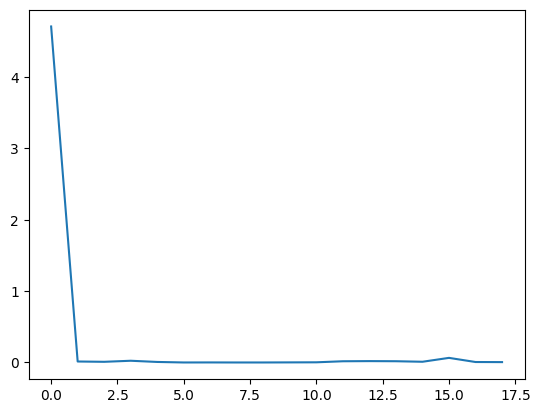

In [75]:
print(episode_loss)
plt.plot(episode_loss)

test_outputs =  tensor([9.2103, 9.2103, 9.2104,  ..., 9.2480, 9.2488, 9.2496])
test_predict =  tensor([8.5590, 8.7526, 8.9461,  ..., 8.7033, 8.7028, 8.7023])
mean square error =  tensor(0.7148)


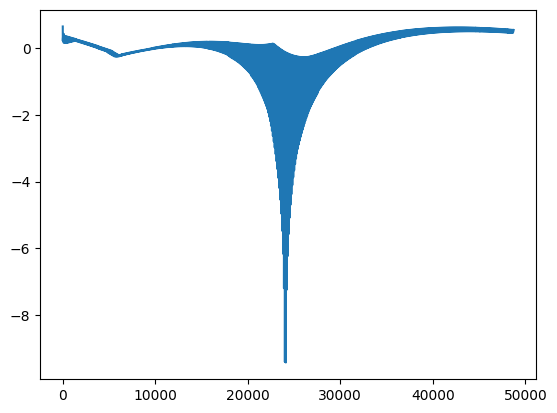

In [76]:
# print(visits)
test_inputs = []
test_outputs = []
for state in range(len(visits)):
    for action in range(len(visits[state])):
        if visits[state,action] == 0.0:
            test_inputs.append([state,action])
            test_outputs.append(Lambda(state,action))

test_inputs_tensor = torch.tensor(test_inputs, dtype=torch.float32)
test_outputs_tensor = torch.tensor(test_outputs, dtype=torch.float32)
test_predict_tensor = model(test_inputs_tensor).detach().reshape(1,-1).squeeze()
error = test_outputs_tensor - test_predict_tensor
# print('test_inputs, shape = ', test_inputs)
print('test_outputs = ', test_outputs_tensor)
print('test_predict = ', test_predict_tensor)
plt.plot(error)
rmse_error = torch.sqrt(torch.mean((test_predict_tensor-test_outputs_tensor)**2))
print('mean square error = ' , rmse_error)
